1.2592325705232799
6.0


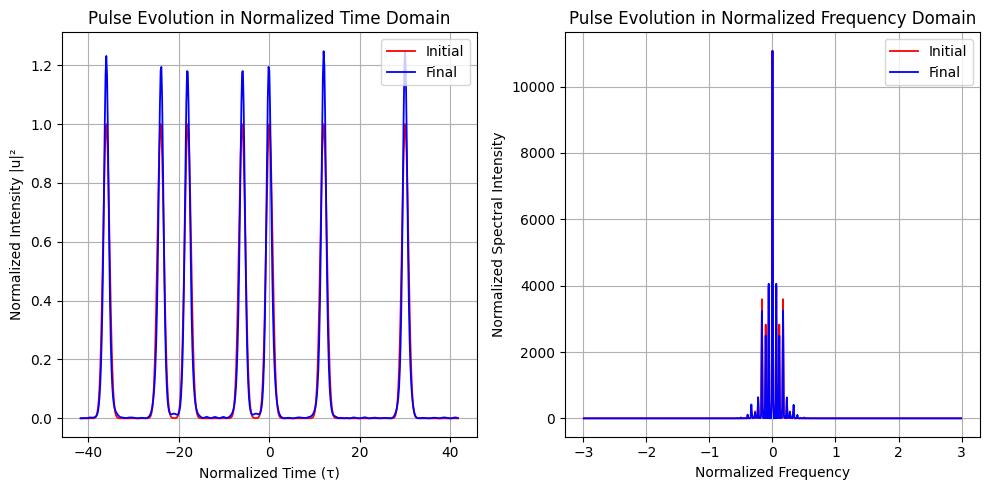

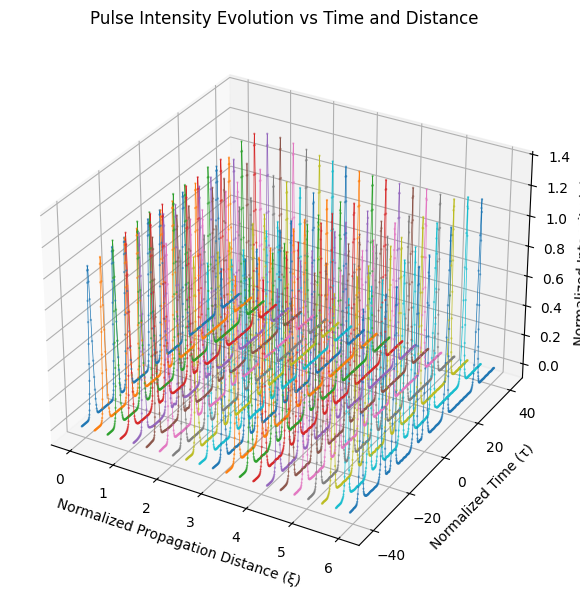

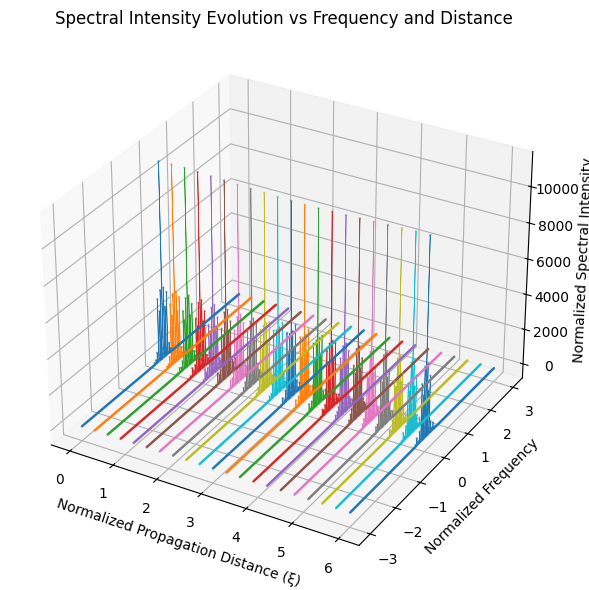

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


p0 = 7.1e-3       
gamma = 1.34      
beta2 = -21.6e-24 
l = 1000          
t0_2 = 3.6e-21    
t0 = np.sqrt(t0_2)  
tmax = 2.5*1e-9       
Ts = 1e-11        
C = 0           


LD = t0**2 / np.abs(beta2)       
LNL = 1 / (gamma * p0)           
N = np.sqrt(LD / LNL)            
print(N)



zmax_norm = l / LD                
dz_norm = 0.1 / LD                    
Nz = int(np.round(zmax_norm / dz_norm))  
print(zmax_norm)

t = np.arange(-tmax, tmax, Ts)    
tau = t / t0                      


dt = t[1] - t[0]                  
dtau = tau[1] - tau[0]            
freq = np.fft.fftfreq(len(t), dt) 
omega = 2 * np.pi * freq          
omega_norm = t0 * omega           


def D_operator_norm(input_signal, dz, omega_norm):
    
    sign_beta2 = -1 if beta2 < 0 else 1
    if np.abs(beta2) < 1e-40:
        sign_beta2 = 0
    return input_signal * np.exp(sign_beta2 * 1j * omega_norm**2 * dz / 2)

def N_operator_norm(input_signal, dz, N):
    
    return input_signal * np.exp(1j * N**2 * np.abs(input_signal)**2 * dz)


num_pulses = 12                           
pulse_spacing = 6                        


pulse_weights = np.array([1, 0, 1, 1, 0,1,1,0,1,0,0,1])  


pulse_train = np.zeros_like(tau, dtype=np.complex128)
for n in range(num_pulses):
    shift = (-num_pulses/2 +n) * pulse_spacing
    # Gaussian pulse formula: exp(-((1 + 1j*C)/2) * (tau-shift)^2)
    pulse = pulse_weights[n] * np.exp(-((1 + 1j * C) / 2) * (tau - shift)**2)
    pulse_train += pulse


input_pulse_norm = pulse_train



def symmetric_ssft_norm(A0, dz, steps, omega_norm, N):
    field_evolution = np.zeros((steps+1, len(A0)), dtype=np.complex128)
    field_evolution[0] = A0.copy()
    A = A0.copy()
    
    for i in range(1, steps+1):
        
        A_w = np.fft.fft(A)
        A_w = D_operator_norm(A_w, dz/2, omega_norm)
        A = np.fft.ifft(A_w)
        
        
        A = N_operator_norm(A, dz, N)
        
        
        A_w = np.fft.fft(A)
        A_w = D_operator_norm(A_w, dz/2, omega_norm)
        A = np.fft.ifft(A_w)
        
        field_evolution[i] = A
        
    return field_evolution


z_norm = np.linspace(0, zmax_norm, Nz+1)
field_evolution_norm = symmetric_ssft_norm(input_pulse_norm, dz_norm, Nz, omega_norm, N)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(tau, np.abs(field_evolution_norm[0])**2, 'r-', linewidth=1.3, label='Initial')
plt.plot(tau, np.abs(field_evolution_norm[-1])**2, 'b-', linewidth=1.3, label='Final')
plt.grid(True)
plt.xlabel('Normalized Time (τ)')
plt.ylabel('Normalized Intensity |u|²')
plt.title('Pulse Evolution in Normalized Time Domain')
plt.legend()

initial_spectrum = np.fft.fftshift(np.fft.fft(field_evolution_norm[0]))
final_spectrum = np.fft.fftshift(np.fft.fft(field_evolution_norm[-1]))
freq_norm = np.fft.fftshift(np.fft.fftfreq(len(tau), dtau))

plt.subplot(1, 2, 2)
plt.plot(freq_norm, np.abs(initial_spectrum)**2, 'r-', linewidth=1.3, label='Initial')
plt.plot(freq_norm, np.abs(final_spectrum)**2, 'b-', linewidth=1.3, label='Final')
plt.grid(True)
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Spectral Intensity')
plt.title('Pulse Evolution in Normalized Frequency Domain')
plt.legend()
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')


z_step = max(1, len(z_norm) // 20)
z_indices = range(0, len(z_norm), z_step)

for i in z_indices:
    z_val = z_norm[i]
    intensity = np.abs(field_evolution_norm[i])**2
    ax.plot([z_val] * len(tau), tau, intensity, linewidth=0.5)
    ax.scatter([z_val] * len(tau), tau, intensity, s=0.5, alpha=0.5)

ax.set_xlabel('Normalized Propagation Distance (ξ)')
ax.set_ylabel('Normalized Time (τ)')
ax.set_zlabel('Normalized Intensity |u|²')
ax.set_title('Pulse Intensity Evolution vs Time and Distance')
plt.tight_layout()
plt.show()


spectrum_evolution = np.zeros((len(z_norm), len(tau)), dtype=np.complex128)
for i in range(len(z_norm)):
    spectrum_evolution[i] = np.fft.fftshift(np.fft.fft(field_evolution_norm[i]))

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

for i in z_indices:
    z_val = z_norm[i]
    spectral_intensity = np.abs(spectrum_evolution[i])**2
    ax.plot([z_val] * len(freq_norm), freq_norm, spectral_intensity, linewidth=0.5)
    ax.scatter([z_val] * len(freq_norm), freq_norm, spectral_intensity, s=0.5, alpha=0.5)

ax.set_xlabel('Normalized Propagation Distance (ξ)')
ax.set_ylabel('Normalized Frequency')
ax.set_zlabel('Normalized Spectral Intensity')
ax.set_title('Spectral Intensity Evolution vs Frequency and Distance')
plt.tight_layout()
plt.show()


Original bits: [1 0 1 1 0 1 1 0 1 0 0 1]
Retrieved bits: [1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]


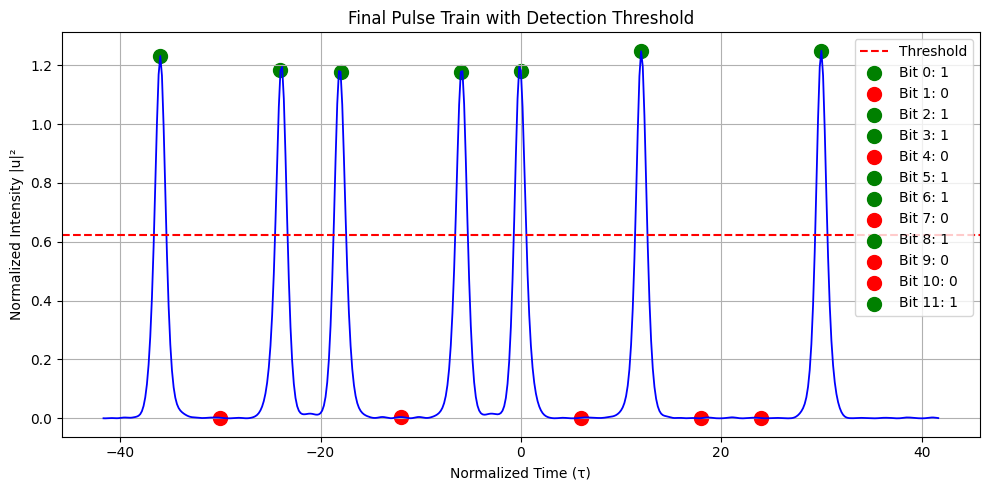

In [3]:
final_pulse = field_evolution_norm[-1]


intensity_final = np.abs(final_pulse)**2


threshold = 0.5 * np.max(intensity_final)


pulse_centers = [(-num_pulses/2 + n) * pulse_spacing for n in range(num_pulses)]


indices = [np.argmin(np.abs(tau - center)) for center in pulse_centers]


retrieved_bits = [1 if intensity_final[idx] > threshold else 0 for idx in indices]


print("Original bits:", pulse_weights)
print("Retrieved bits:", retrieved_bits)


plt.figure(figsize=(10, 5))
plt.plot(tau, intensity_final, 'b-', linewidth=1.3)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.grid(True)
plt.xlabel('Normalized Time (τ)')
plt.ylabel('Normalized Intensity |u|²')
plt.title('Final Pulse Train with Detection Threshold')


for i, center in enumerate(pulse_centers):
    idx = np.argmin(np.abs(tau - center))
    bit = retrieved_bits[i]
    color = 'green' if bit == 1 else 'red'
    plt.scatter(tau[idx], intensity_final[idx], color=color, s=100, 
                label=f'Bit {i}: {bit}')

plt.legend()
plt.tight_layout()
plt.show()


Original bits: [1 0 1 1 0 1 1 0 1]
CRC bits: [0 1 1 0]
(Data+CRC): [1 0 1 1 0 1 1 0 1 0 1 1 0]
No bit flipped
Corrupted sequence sent: [1 0 1 1 0 1 1 0 1 0 1 1 0]

--- Receiver ---
Retrieved sequence: [1 0 1 1 0 1 1 0 1 0 1 1 0]
Calculated Remainder: 0000
No errors detected: Remainder is zero. Data accepted.
Accepted data bits: [1 0 1 1 0 1 1 0 1]


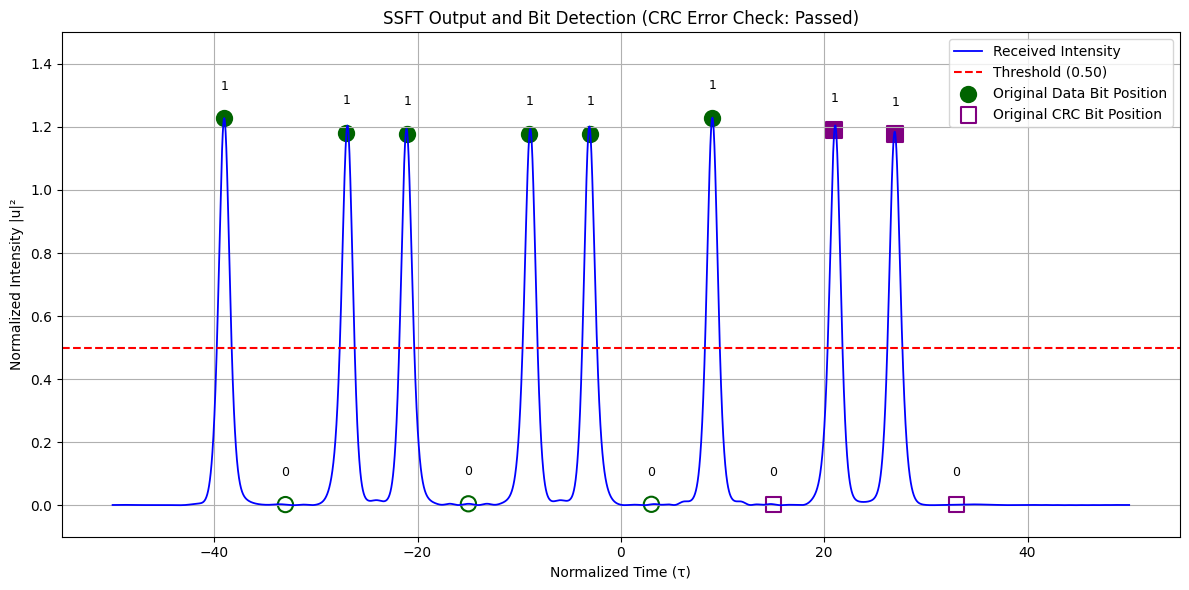

In [4]:
p0 = 7.1e-3      
gamma = 1.34     
beta2 = -21.6e-24 
l = 1000         
t0_2 = 3.6e-21   
t0 = np.sqrt(t0_2)  
tmax = 3*1e-9     
Ts = 1e-12        
C = 0             


LD = t0**2 / np.abs(beta2)     
LNL = 1 / (gamma * p0)         
N = np.sqrt(LD / LNL)          

zmax_norm = l / LD             
dz_norm = 0.1 / LD             
Nz = int(np.round(zmax_norm / dz_norm)) 


t = np.arange(-tmax, tmax, Ts)   
tau = t / t0                     

dt = t[1] - t[0]                 
dtau = tau[1] - tau[0]           
freq = np.fft.fftfreq(len(t), dt) 
omega = 2 * np.pi * freq         
omega_norm = t0 * omega          


def D_operator_norm(input_signal, dz, omega_norm):
    sign_beta2 = -1 if beta2 < 0 else 1
    if np.abs(beta2) < 1e-40: 
        sign_beta2 = 0
    return input_signal * np.exp(sign_beta2 * 1j * omega_norm**2 * dz / 2)

def N_operator_norm(input_signal, dz, N):
    return input_signal * np.exp(1j * N**2 * np.abs(input_signal)**2 * dz)


original_bits = np.array([1, 0, 1, 1, 0, 1, 1, 0, 1]) 

def crc_remainder(input_bitstring, polynomial_bitstring, initial_filler):
    polynomial_length = len(polynomial_bitstring)
    padded_input = list(input_bitstring + initial_filler) 
    polynomial = list(polynomial_bitstring)
    
    for i in range(len(input_bitstring)):
        if padded_input[i] == '1':
            for j in range(polynomial_length):
                
                padded_input[i + j] = str(int(padded_input[i + j]) ^ int(polynomial[j]))

    remainder = ''.join(padded_input[-(polynomial_length-1):])
    return remainder

def bits_to_string(bits):
    return ''.join(str(int(b)) for b in bits)

polynomial = '10011' 
n = len(polynomial) - 1 
initial_filler = '0' * n 
original_bitstring = bits_to_string(original_bits)
original_crc = crc_remainder(original_bitstring, polynomial, initial_filler)
original_crc_bits = np.array([int(bit) for bit in original_crc])


protected_bits = np.concatenate((original_bits, original_crc_bits))


e = np.random.randint(0, 2)
corrupted_bits = protected_bits.copy()
if(e==1):
    #np.random.seed(42) 
    bit_to_flip = np.random.randint(0, len(protected_bits)) # Flip a bit in the combined sequence
    corrupted_bits[bit_to_flip] = 1 - corrupted_bits[bit_to_flip] 

print(f"Original bits: {original_bits}")
print(f"CRC bits: {original_crc_bits}")
print(f"(Data+CRC): {protected_bits}")
if(e==1):
    print(f"Bit flipped at position: {bit_to_flip}")
else:
     print(f"No bit flipped")
print(f"Corrupted sequence sent: {corrupted_bits}")


num_pulses = len(corrupted_bits) 
pulse_spacing = 6 

pulse_train = np.zeros_like(tau, dtype=np.complex128)
for k in range(num_pulses):
    shift = (-num_pulses/2 + k) * pulse_spacing
    pulse = corrupted_bits[k] * np.exp(-((1 + 1j * C) / 2) * (tau - shift)**2)
    pulse_train += pulse

input_pulse_norm = pulse_train


def symmetric_ssft_norm(A0, dz, steps, omega_norm, N):
    field_evolution = np.zeros((steps+1, len(A0)), dtype=np.complex128)
    field_evolution[0] = A0.copy()
    A = A0.copy()
    
    for i in range(1, steps+1):
        A_w = np.fft.fft(A)
        A_w = D_operator_norm(A_w, dz/2, omega_norm)
        A = np.fft.ifft(A_w)
        
        A = N_operator_norm(A, dz, N)
        
        A_w = np.fft.fft(A)
        A_w = D_operator_norm(A_w, dz/2, omega_norm)
        A = np.fft.ifft(A_w)
        
        field_evolution[i] = A
        
    return field_evolution

z_norm = np.linspace(0, zmax_norm, Nz+1)
field_evolution_norm = symmetric_ssft_norm(input_pulse_norm, dz_norm, Nz, omega_norm, N)


final_pulse = field_evolution_norm[-1]
intensity_final = np.abs(final_pulse)**2
threshold = 0.5 #* np.max(intensity_final[intensity_final > 1e-5]) 

pulse_centers = [(-num_pulses/2 + k) * pulse_spacing for k in range(num_pulses)]
indices = [np.argmin(np.abs(tau - center)) for center in pulse_centers]
retrieved_bits = np.array([1 if intensity_final[idx] > threshold else 0 for idx in indices])


def crc_check(received_bitstring, polynomial_bitstring):
    polynomial_length = len(polynomial_bitstring)
    data_length = len(received_bitstring)
    
    data = list(received_bitstring) 
    polynomial = list(polynomial_bitstring)

    
    for i in range(data_length - (polynomial_length - 1)):
        if data[i] == '1': 
            for j in range(polynomial_length):
                data[i + j] = str(int(data[i + j]) ^ int(polynomial[j])) 

    
    remainder = ''.join(data[-(polynomial_length-1):])
    return remainder

retrieved_protected_string = bits_to_string(retrieved_bits)
final_remainder_str = crc_check(retrieved_protected_string, polynomial)


error_detected = any(bit == '1' for bit in final_remainder_str)

print("\n--- Receiver ---")
print(f"Retrieved sequence: {retrieved_bits}")
print(f"Calculated Remainder: {final_remainder_str}")

if error_detected:
    print("ERROR DETECTED: Remainder is non-zero. Data rejected.")
else:
    
    retrieved_data_bits = retrieved_bits[:len(original_bits)]
    print("No errors detected: Remainder is zero. Data accepted.")
    print(f"Accepted data bits: {retrieved_data_bits}")


plt.figure(figsize=(12, 6))
plt.plot(tau, intensity_final, 'b-', linewidth=1.3, label='Received Intensity')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')
plt.grid(True)
plt.xlabel('Normalized Time (τ)')
plt.ylabel('Normalized Intensity |u|²')
plt.title(f'SSFT Output and Bit Detection (CRC Error Check: {"Detected" if error_detected else "Passed"})')
plt.ylim(-0.1,1.5) 


data_color = 'darkgreen'
crc_color = 'purple'
error_color = 'red'
original_label_done = False
retrieved_label_done = False
crc_label_done = False
error_label_done = False

for i, center in enumerate(pulse_centers):
    idx = np.argmin(np.abs(tau - center))
    retrieved_bit = retrieved_bits[i]
    original_sent_bit = corrupted_bits[i] 
    
    is_data_bit = i < len(original_bits)
    marker = 'o' if is_data_bit else 's' 
    
    
    if retrieved_bit != original_sent_bit:
        color = error_color
        label = 'Error in Transmission/Retrieval' if not error_label_done else None
        error_label_done = True
    elif is_data_bit:
        color = data_color
        label = 'Original Data Bit Position' if not original_label_done else None
        original_label_done = True
    else:
        color = crc_color
        label = 'Original CRC Bit Position' if not crc_label_done else None
        crc_label_done = True
        
    
    plt.scatter(tau[idx], intensity_final[idx], 
                color=color, 
                marker=marker, 
                s=120, 
                label=label, 
                facecolors='none' if retrieved_bit == 0 else color, 
                linewidth=1.5)
    
    
    plt.text(tau[idx], intensity_final[idx] + 0.1 * np.max(intensity_final), str(retrieved_bit), 
             ha='center', va='top', fontsize=9, color='black')
             
    
    if(e==1):
        if i == bit_to_flip:
             plt.scatter(tau[idx], -0.05, color=error_color, marker='^', s=100, label=f'Original Bit Flipped at Pos {i}')


plt.legend(loc='best')
plt.tight_layout()
plt.show()
